# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *A non-local algorithm for image denoising* autorstwa Antoni Buades, Bartomeu Coll, i Jean Michel Morel na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation}

gdzie:
- \begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in  V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation},
- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując. Jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os
from time import time

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

mat = loadmat("MR_data.mat")

#### funkcje z poprzedniej części zadania

In [2]:
def fgaussian(size, sigma):
    m = n = size
    h, k = m//2, n//2
    x, y = np.mgrid[-h:h+1, -k:k+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return g/g.sum() 

def count_filter(window, kernel):
    return np.sum(window*kernel)

def show_filtered(image, filtered):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    plt.gray()

    for axis in ax: axis.axis('off')

    ax[0].set_title('obraz oryginalny')
    ax[1].set_title('po filtracji')
    ax[2].set_title('moduł z różnicy')

    ax[0].imshow(image, vmin=0, vmax=255)
    ax[1].imshow(filtered, vmin=0, vmax=255)
    ax[2].imshow(5*np.abs(image.astype('int') - filtered.astype('int')))
    
    plt.show()
    
def convolution(image, window_size, sigma):
    rows, cols = image.shape
    kernel = fgaussian(window_size, sigma)
    new_image = np.zeros(image.shape)
    
    offset = window_size//2
    
    for i in range(offset, rows - offset):
        for j in range(offset, cols - offset):
            window = image[i-offset:i+offset+1, j-offset:j+offset+1]
            new_image[i, j] = count_filter(window, kernel)
    
    return new_image

def bilateral(image, window_size, sigma_s, sigma_r):
    rows, cols = image.shape
    new_image = np.zeros(image.shape)
    
    offset = window_size//2
    
    kernel_dist = fgaussian(window_size, sigma_s)
    
    def new_value(window, kernel_dist, sigma_r):
        kernel_value = np.zeros((window_size, window_size))
        
        center_value = window[window_size//2, window_size//2]

        for x in range(window_size):
            for y in range(window_size):
                kernel_value[x, y] = np.exp(-(window[x, y] - center_value)**2/(2*sigma_r**2))

        kernel = kernel_dist * kernel_value
        kernel /= np.sum(kernel)
        
        return count_filter(window, kernel)
        
    for i in range(offset, rows - offset):
        for j in range(offset, cols - offset):
            window = image[i-offset:i+offset+1, j-offset:j+offset+1].astype('float')
            new_image[i, j] = new_value(window, kernel_dist, sigma_r)
    
    return new_image

#### filtracja Non-local Means

In [3]:
def nlm(image, window_size, context_size, sigma_s, sigma_r, alpha):
    rows, cols = image.shape
    new_image = np.zeros(image.shape)
    
    context_offset = context_size//2
    window_offset = window_size//2
    offset = context_offset + window_offset
    
    kernel_context = fgaussian(context_size, sigma_s)
    
    for x in range(offset, rows - offset):
        for y in range(offset, cols - offset):
            center_values = image[x-context_offset:x+context_offset+1, y-context_offset:y+context_offset+1].astype('float')
            center_v = center_values * kernel_context
            
            weights = np.zeros((window_size, window_size))
            
            for i in range(x - window_offset, x + window_offset + 1):
                for j in range(y - window_offset, y + window_offset + 1):
                    x_values = image[i-context_offset:i+context_offset+1, j-context_offset:j+context_offset+1].astype('float')
                    x_v = x_values * kernel_context
                    
                    norm = np.linalg.norm(center_v - x_v)
                    weights[i-x+window_offset, j-y+window_offset] = np.exp(-norm**2/(alpha*sigma_r**2))
            

            window = image[x-window_offset:x+window_offset+1, y-window_offset:y+window_offset+1]
            weights /= np.sum(weights)
                
            new_image[x, y] = count_filter(window, weights)
    
    return new_image

#### parametry

In [4]:
image = mat['I_noisy2']
window_size = 7
context_size = 3
alpha = 0.1
sigma_s = 1000
sigma_r = 15

#### porównanie wyników filtracji

* zwykła filtracja z maską gaussowską

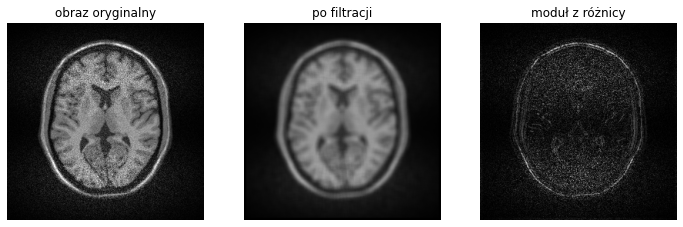

In [5]:
start = time()
filtered = convolution(image, window_size, sigma_s)
show_filtered(image, filtered)
convolution_time = time() - start

* filtracja bilateralna

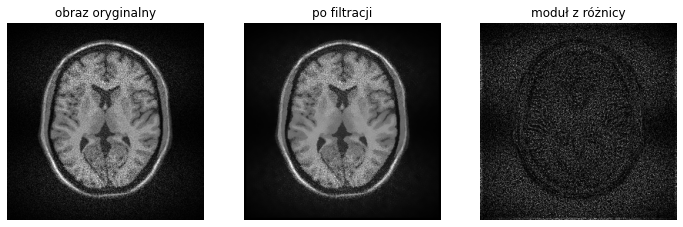

In [6]:
start = time()
bilateral_filtered = bilateral(image, window_size, sigma_s, sigma_r)
show_filtered(image, bilateral_filtered)
bilateral_time = time() - start

* nlm

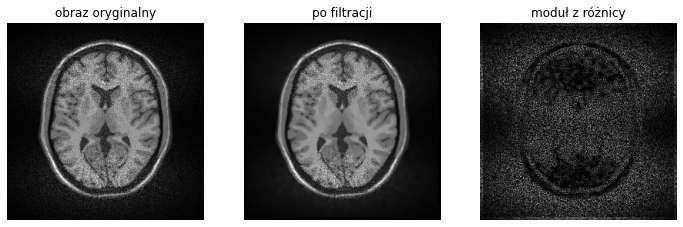

In [7]:
start = time()
nlm_filtered = nlm(image, window_size, context_size, sigma_s, sigma_r, alpha)
show_filtered(image, nlm_filtered)
nlm_time = time() - start

Przy pomocy filtru bilateralnego oraz metody Non-local Means otrzymujemy dużo lepszy efekt filtracji w porównaniu do zwykłej maski konwolucyjnej gaussowskiej. Otrzymane obrazy są częściowo rozmyte, przez co zredukowana została ilość szumów, jednak nie zostały zamazane krawędzie. W mojej ocenie najlepej poradziła sobie metoda NLM, chociaż na pewno można by było efekt jeszcze poprawić, dobierając odpowiednie parametry alfa i sigma, jak również zwiększając okna kontekstu i obszaru poszukiwań.

#### porównanie czasu

In [8]:
print(f'zwykła konwolucja: {convolution_time:.2f}s')
print(f'filtr bilateralny:  {bilateral_time:.2f} s')
print(f'non local means: {nlm_time:.2f} s')

zwykła konwolucja: 0.91s
filtr bilateralny:  10.94 s
non local means: 49.63 s


Czas działania metody NLM jest ogromny nawet dla tak małych obrazków. Czas metody bilateralnej także nie jest mały, ale zdecydowanie mniejszy od NLM, w tym przypadku aż 5-krotnie. Najprostsza stała maska daje oczywiście najlepszy czas, kosztem jakości obrazu.

M. Hawryluk, 2022